In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [121]:
titanic_data = pd.read_csv('Titanic_coursework_entire_dataset_23-24.csv')

<Axes: >

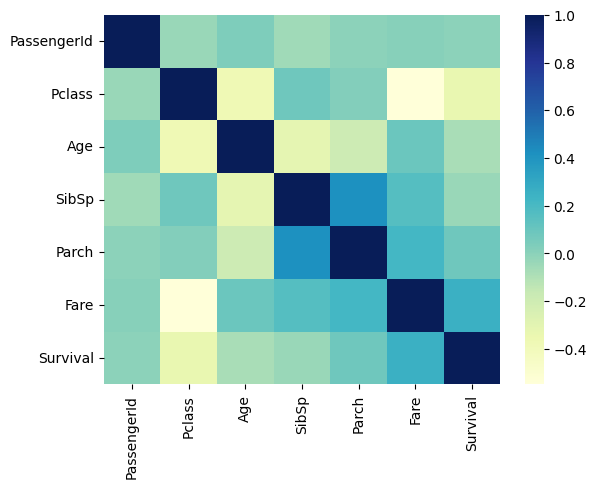

In [122]:
import seaborn as sns

sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")

In [123]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survival", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

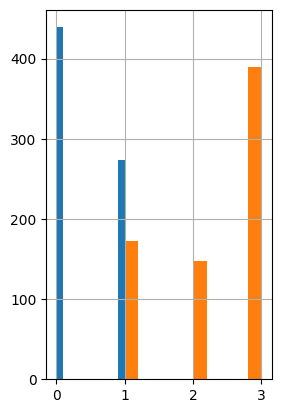

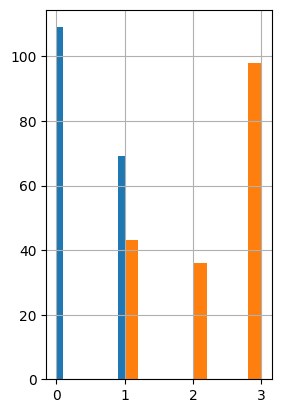

In [124]:
plt.subplot(1,2,1)
strat_train_set['Survival'].hist()
strat_train_set['Pclass'].hist()

plt.show()

plt.subplot(1,2,1)
strat_test_set['Survival'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [125]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 246 to 651
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       711 non-null    float64
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          571 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Embarked     711 non-null    object 
 10  Survival     712 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 66.8+ KB


In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [127]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()

        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()

        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

In [128]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Sex", "N"], axis=1, errors="ignore")

In [129]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [130]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [131]:
strat_train_set

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survival,C,S,Q,Female,Male
246,247,3.0,25.000000,0,0,7.7750,0,0.0,0.0,1.0,1.0,0.0
32,33,3.0,29.218634,0,0,7.7500,1,0.0,1.0,0.0,1.0,0.0
31,32,1.0,29.218634,1,0,146.5208,1,1.0,0.0,0.0,1.0,0.0
450,451,2.0,36.000000,1,2,27.7500,0,0.0,0.0,1.0,0.0,1.0
779,780,3.0,13.000000,0,0,7.2292,1,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
179,180,3.0,36.000000,0,0,0.0000,0,0.0,0.0,1.0,0.0,1.0
586,587,2.0,47.000000,0,0,15.0000,0,0.0,0.0,1.0,0.0,1.0
324,325,3.0,29.218634,8,2,69.5500,0,0.0,0.0,1.0,0.0,1.0
396,397,3.0,31.000000,0,0,7.8542,0,0.0,0.0,1.0,1.0,0.0


In [132]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 246 to 651
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       711 non-null    float64
 2   Age          712 non-null    float64
 3   SibSp        712 non-null    int64  
 4   Parch        712 non-null    int64  
 5   Fare         712 non-null    float64
 6   Survival     712 non-null    int64  
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 72.3 KB


In [133]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survival'], axis=1)
y = strat_train_set['Survival']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_gird = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_gird, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [135]:
final_clf = grid_search.best_estimator_

In [136]:
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=500)

In [137]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [138]:
X_test = strat_test_set.drop(['Survival'], axis=1)
y_test = strat_test_set['Survival']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [139]:
final_clf.score(X_data_test, y_data_test)

0.8314606741573034

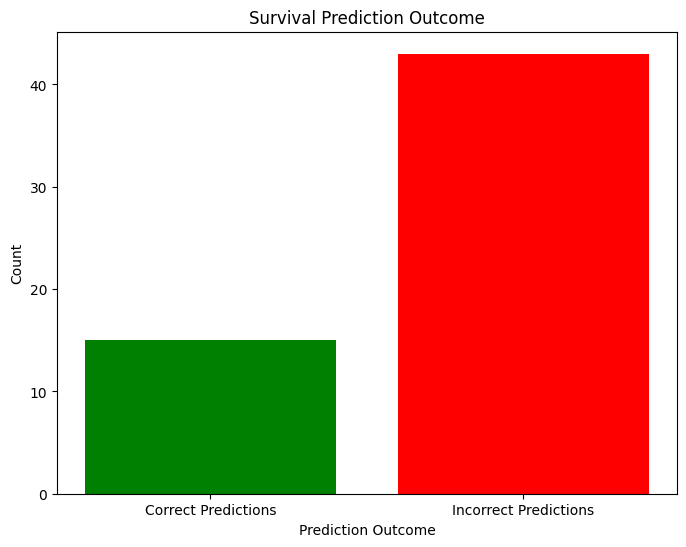

In [140]:
correct_predictions = ((y_data_test == 1) & (predicted_survival == 1)).sum()
incorrect_predictions = ((y_data_test == 0) & (predicted_survival == 1)).sum()

plt.figure(figsize=(8, 6))
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [correct_predictions, incorrect_predictions], color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Count')
plt.title('Survival Prediction Outcome')
plt.show()


In [141]:
final_data = pipeline.fit_transform(titanic_data)

In [142]:
final_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survival,C,S,Q,Female,Male
0,1,3.0,22.000000,1,0,7.2500,0,0.0,0.0,1.0,0.0,1.0
1,2,1.0,38.000000,1,0,71.2833,1,1.0,0.0,0.0,1.0,0.0
2,3,3.0,26.000000,0,0,7.9250,1,0.0,0.0,1.0,1.0,0.0
3,4,1.0,35.000000,1,0,53.1000,1,0.0,0.0,1.0,1.0,0.0
4,5,3.0,35.000000,0,0,8.0500,0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,2.0,27.000000,0,0,13.0000,0,0.0,0.0,1.0,0.0,1.0
886,887,1.0,19.000000,0,0,30.0000,1,0.0,0.0,1.0,1.0,0.0
887,888,3.0,29.699118,1,2,23.4500,0,0.0,0.0,1.0,1.0,0.0
888,889,1.0,26.000000,0,0,30.0000,1,1.0,0.0,0.0,0.0,1.0


# Decision Tree Classifier Model

In [143]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X, y)

DecisionTreeClassifier()

In [144]:
decision_tree_score = decision_tree.score(X_test, y_test)
decision_tree_score

0.7752808988764045

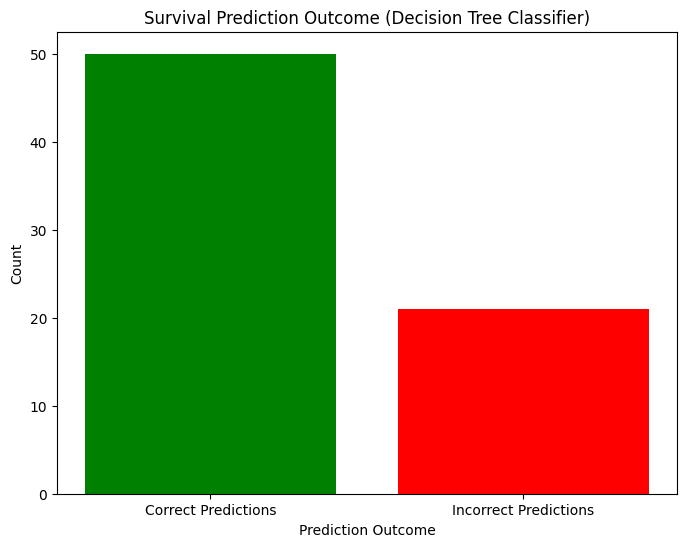

In [145]:
decision_tree_predicted_survival = decision_tree.predict(X_test)
decision_tree_correct_predictions = ((y_test == 1) & (decision_tree_predicted_survival == 1)).sum()
decision_tree_incorrect_predictions = ((y_test == 0) & (decision_tree_predicted_survival == 1)).sum()

plt.figure(figsize=(8, 6))
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [decision_tree_correct_predictions, decision_tree_incorrect_predictions], color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Count')
plt.title('Survival Prediction Outcome (Decision Tree Classifier)')
plt.show()

# XGBoost Classifier Model

In [146]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()

xgb_classifier.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [147]:
xgb_classifier_score = xgb_classifier.score(X_test, y_test)
xgb_classifier_score

0.8202247191011236

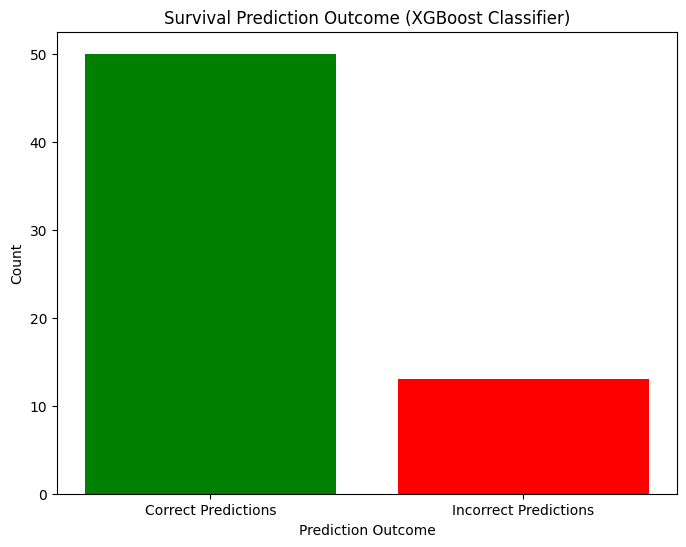

In [148]:
xgb_classifier_predicted_survival = xgb_classifier.predict(X_test)
xgb_classifier_correct_predictions = ((y_test == 1) & (xgb_classifier_predicted_survival == 1)).sum()
xgb_classifier_incorrect_predictions = ((y_test == 0) & (xgb_classifier_predicted_survival == 1)).sum()

plt.figure(figsize=(8, 6))
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [xgb_classifier_correct_predictions, xgb_classifier_incorrect_predictions], color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Count')
plt.title('Survival Prediction Outcome (XGBoost Classifier)')
plt.show()